# 오토인코더

In [8]:
# 라이브러리 호출
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [9]:
# 네트워크(신경망) 생성
input_image=tf.keras.layers.Input(shape=(784,)) # 입력의 크기 (784,)
encoded_input=tf.keras.layers.Dense(32,activation='relu')(input_image) # 입력을 인코딩에 적용
decoded_output=tf.keras.layers.Dense(784,activation='sigmoid')(encoded_input) # 인코딩 출력을 디코딩에 적용하여 재구성(입력의 원래 크기로 변환)
autoencoder=tf.keras.models.Model(input_image,decoded_output) # 인코더와 디코더로 구성된 오토인코더 모델 생성

In [10]:
# 모델 컴파일
autoencoder.compile(optimizer='adam',loss='binary_crossentropy')

In [11]:
# 데이터셋 준비
(X_train, _), (X_test, _) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
X_train = X_train.reshape((len(X_train),np.prod(X_train.shape[1:])))
X_test = X_test.reshape((len(X_test),np.prod(X_test.shape[1:])))

In [12]:
# 모델 훈련
autoencoder.fit(X_train,X_train,epochs=30,batch_size=256,shuffle=True,validation_data=(X_test,X_test))

Epoch 1/30
235/235 [==============================] - 1s 4ms/step - loss: 0.2731 - val_loss: 0.1821
Epoch 2/30
235/235 [==============================] - 1s 4ms/step - loss: 0.1667 - val_loss: 0.1517
Epoch 3/30
235/235 [==============================] - 1s 4ms/step - loss: 0.1434 - val_loss: 0.1337
Epoch 4/30
235/235 [==============================] - 1s 4ms/step - loss: 0.1286 - val_loss: 0.1214
Epoch 5/30
235/235 [==============================] - 1s 3ms/step - loss: 0.1183 - val_loss: 0.1129
Epoch 6/30
235/235 [==============================] - 1s 4ms/step - loss: 0.1111 - val_loss: 0.1069
Epoch 7/30
235/235 [==============================] - 1s 4ms/step - loss: 0.1061 - val_loss: 0.1026
Epoch 8/30
235/235 [==============================] - 1s 4ms/step - loss: 0.1023 - val_loss: 0.0993
Epoch 9/30
235/235 [==============================] - 1s 4ms/step - loss: 0.0995 - val_loss: 0.0974
Epoch 10/30
235/235 [==============================] - 1s 4ms/step - loss: 0.0974 - val_loss: 0.0953

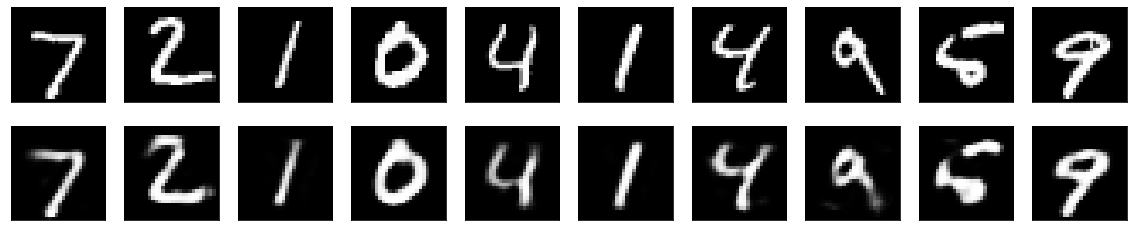

In [14]:
# 이미지 시각화
reconstructed_img=autoencoder.predict(X_test)
n=10 # 입력/출력 이미지 열개를 표현
plt.figure(figsize=(20,4))
for i in range(n):
    ax=plt.subplot(2,n,i+1) # 실제 이미지 시각화
    plt.imshow(X_test[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax=plt.subplot(2,n,i+1+n) # 재구성된 이미지 시각화
    plt.imshow(reconstructed_img[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# 변형 오토인코더

In [15]:
pip install tensorflow_probability # 확률적 추론 및 통계 분석을 위한 라이브러리

Note: you may need to restart the kernel to use updated packages.


In [17]:
# 필요한 라이브러리 추출
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
%matplotlib inline
from IPython import display
import pandas as pd
import tensorflow_probability as tfp
ds = tfp.distributions

In [18]:
# 초기값 설정
TRAIN_BUF=60000
TEST_BUF=10000
BATCH_SIZE=512
N_TRAIN_BATCHES =int(TRAIN_BUF/BATCH_SIZE)
N_TEST_BATCHES = int(TEST_BUF/BATCH_SIZE)

In [19]:
# fashion_mnist 데이터셋 로딩 및 데이터셋 분리
(train_images,train_labels),(test_images,test_labels)=tf.keras.datasets.fashion_mnist.load_data() # 훈련, 검증 데이터셋으로 분리
train_images=train_images.reshape(train_images.shape[0],28,28,1).astype('float32')/255.0
test_images=test_images.reshape(test_images.shape[0],28,28,1).astype('float32')/255.0

train_dataset = (
    tf.data.Dataset.from_tensor_slices(train_images)
    .shuffle(60000)
    .batch(512)
) # 훈련 데이터셋 준비
test_dataset = (
    tf.data.Dataset.from_tensor_slices(test_images)
    .shuffle(10000)
    .batch(512)
) # 검증 데이터셋 준비

In [26]:
# 변형 오토인코더 네트워크 생성
class VAE(tf.keras.Model):
    def __init__(self, **kwargs):
        super(VAE, self).__init__()
        self.__dict__.update(kwargs)

        self.enc = tf.keras.Sequential(self.enc)
        self.dec = tf.keras.Sequential(self.dec)

    def encode(self, x):
        mu, sigma = tf.split(self.enc(x), num_or_size_splits=2, axis=1)
        return ds.MultivariateNormalDiag(loc=mu, scale_diag=sigma) # 인코더에서 평균과 표준편차를 정의하고 z의 평균과 분산을 모수로 하는 정규 분포 생성
    def reparameterize(self, mean, logvar):
        epsilon = tf.random.normal(shape=mean.shape)
        return epsilon * tf.exp(logvar * 0.5) + mean # 1

    def reconstruct(self, x):
        mu, _ = tf.split(self.enc(x), num_or_size_splits=2, axis=1)
        return self.decode(mu) # 입력 데이터를 출력 데이터로 재구성

    def decode(self, z):
        return self.dec(z) # 인코더가 만든 z를 받아 입력 데이터(x)를 복원

    def loss_function(self, x):
        q_z = self.encode(x)
        z = q_z.sample()
        x_recon = self.decode(z)
        p_z = ds.MultivariateNormalDiag(
          loc=[0.] * z.shape[-1], scale_diag=[1.] * z.shape[-1]
          )
        kl_div = ds.kl_divergence(q_z, p_z)
        latent_loss = tf.reduce_mean(tf.maximum(kl_div, 0))
        recon_loss = tf.reduce_mean(tf.reduce_sum(tf.math.square(x - x_recon), axis=0))
        return recon_loss, latent_loss # 2

    def gradients(self, x):
        with tf.GradientTape() as tape:
            loss = self.loss_function(x)
        return tape.gradient(loss, self.trainable_variables) # 3

    @tf.function
    def train(self, train_x):
        gradients = self.gradients(train_x)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

- 1 : reparemeterize함수는 z분포를 이용하여 z벡터를 샘플링. z는 가우시안 분포로 정했기 때문에, 평균과 표준편차를 이용하여  z에 노이즈를 적용하여 샘플링. 그리고 샘플링한 z벡터를 디코더에 다시 통과시켜서 입력과 동일한 데이터(x')를 만들어 내는 작업 진행. 샘플링 작업에 노이즈를 부여해서 z벡터를 여러개 뽑고, p(x|z)를 거치면서 기존 입력 데이터와 다른 분포를 가지는 데이터 출력
- 2 : 손실을 구하는 함수, 변분추론으로 p(x|z)와 q(z)사이의 쿨백-라이블러 발산을 계산하고 이가 줄어드는 족으로 q(z)를 조금씩 업데이트. 즉 변형 오토인코더에서 손실함수가 쿨백-라이블러 발산이 됨.
    - 변분추론 : 이상적인 확률 분포를 모르지만, 이를 추정하고자 다루기 쉬운 분포를 가정하고, 이 호가률 분포의 모수를 바꾸어 가며 이상적 확률 분포에 근사하게 만들어 그 확률분포를 대신 사용
- 3 : GradientTape는 미분을 자동으로 계산함. 즉 미분을 자동 계산해서 동적으로 기울기 값들을 확인할 수 있는 장점이 있음. 따라서 tape.gradient(loss, self.trainable_variables)는 손실에 대한 self.trainable_variables의 미분값을 게산한다는 의미

In [27]:
#  인코더와 디코더 네트워크 생성
encoder = [
    tf.keras.layers.InputLayer(input_shape=(28,28,1)),
    tf.keras.layers.Conv2D(
        filters=32, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=2*2),
] # 1

decoder = [
    tf.keras.layers.Dense(units=7 * 7 * 64, activation="relu"),
    tf.keras.layers.Reshape(target_shape=(7, 7, 64)),
    tf.keras.layers.Conv2DTranspose(
        filters=64, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=32, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=1, kernel_size=3, strides=(1, 1), padding="SAME", activation="sigmoid"
    ),
] # 2

 - 1 : 인코더 역할은 데이터가 주어졌을 때 디코더가 원래 데이터로 잘 복원할 수 있는 z를 샘플링하여 이상적인 확률 분포p(z|x)를 찾는 것. 변형 오토인코더에서는 이상적인 확률 분포를 찾는데 변분추론 사용
 - 2 : 디코더는 추출한 샘플을 입력으로 받아 다시 원본 데이터와 유사한 데이터를 재구축하는 역할 수행

In [28]:
# 모델 정의
model=VAE(
    enc=encoder,
    dec=decoder,
    optimizer=tf.keras.optimizers.Adam(1e-3)
)

In [29]:
# 모델 훈련 결과 시각화
example_data = next(iter(test_dataset))
def plot_reconstruction(model, example_data, nex=8, zm=2):

    example_data_reconstructed = model.reconstruct(example_data)
    samples = model.decode(tf.random.normal(shape=(BATCH_SIZE, 2)))
    fig, axs = plt.subplots(ncols=nex, nrows=3, figsize=(zm * nex, zm * 3))
    for axi, (dat, lab) in enumerate(
        zip(
            [example_data, example_data_reconstructed, samples],
            ["data", "data recon", "samples"],
        )
    ):
        for ex in range(nex):
            axs[axi, ex].matshow(
                dat.numpy()[ex].squeeze(), cmap=plt.cm.Greys, vmin=0, vmax=1
            )
            axs[axi, ex].axes.get_xaxis().set_ticks([])
            axs[axi, ex].axes.get_yaxis().set_ticks([])
        axs[axi, 0].set_ylabel(lab)
    plt.show()

In [32]:
# 손실 정보 저장
losses=pd.DataFrame(columns=['recon_loss','latent_loss'])

Epoch: 49 | recon_loss: 20.838150024414062 | latent_loss: 4.343405723571777


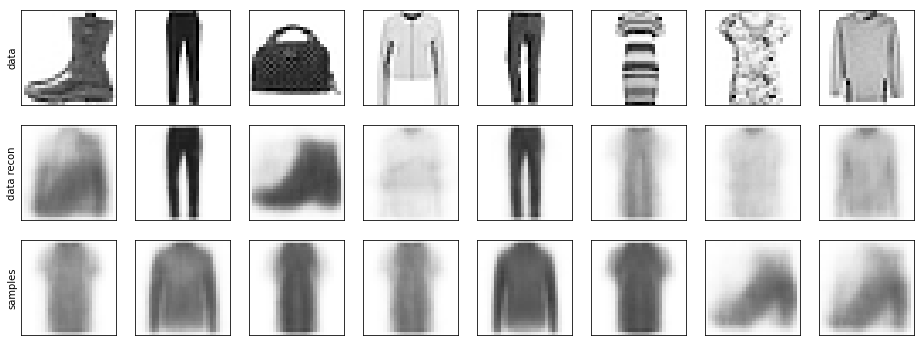

In [33]:
# 모델 훈련
n_epochs = 50

for epoch in range(n_epochs):
    for batch, train_x in tqdm(
        zip(range(N_TRAIN_BATCHES), train_dataset), total=N_TRAIN_BATCHES):
        model.train(train_x) # 훈련 데이터셋을 사용하여 훈련
        loss = []
        
    for batch, test_x in tqdm(
        zip(range(N_TEST_BATCHES), test_dataset), total=N_TEST_BATCHES
): 
        loss.append(model.loss_function(train_x))
    losses.loc[len(losses)] = np.mean(loss, axis=0) 
    display.clear_output()
    print(
        "Epoch: {} | recon_loss: {} | latent_loss: {}".format(
            epoch, losses.recon_loss.values[-1], losses.latent_loss.values[-1]
        )
    ) # 재구성 오차(reconstruction_loss)와 인코더-디코더 사이의 오차(latent_loss) 출력
    
    plot_reconstruction(model, example_data) # 결과를 시각화

- 에포크를 늘리면 선명한 결과를 얻을 수 있음

# GAN(적대적 생성 신경망)

In [34]:
# 라이브러리 호출
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.layers import Reshape,Dense,Dropout,LeakyReLU,Conv2DTranspose,Conv2D,Flatten,BatchNormalization
from tensorflow.keras import Model,Sequential
from tensorflow.keras.datasets import mnist
import time
from IPython import display

In [35]:
# MNIST 데이터셋 내려받기 및 전처리
(x_train, y_train), (x_test, y_test) = mnist.load_data() # load_data()를 사용하여 MNIST데이터셋을 내려받음
train_images = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # 0~255의 값을 갖는 이미지를 -1~1의 벡터 값을 갖도록 변환
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(60000).batch(256) # 벡터 값들을 섞고 이미지 256개의 배치로 변환

In [37]:
# 생성자 네트워크 생성
def create_generator():
    generator=Sequential()
    generator.add(Dense(7*7*256, input_dim=100)) # 1
    generator.add(LeakyReLU(0.2))
    
    
    generator.add(Reshape((7, 7, 256)))
    
    generator.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=True)) # 2
    generator.add(BatchNormalization()) # 이미지에서 노이즈를 줄이는 정규화 목적으로 사용
    generator.add(LeakyReLU(0.2)) # 활성화 함수로 리키렐루 사용
    generator.add(Dropout(0.3))
       
    generator.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=True))
    generator.add(BatchNormalization())
    generator.add(LeakyReLU(0.2))
    
    generator.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=True, activation='tanh'))
    
    return generator
g=create_generator()
g.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 12544)             1266944   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape_2 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 7, 7, 128)        819328    
 ranspose)                                                       
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 128)        512       
 ormalization)                                                   
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 128)        

- 1 : 은닉층 파라미터
    - 7*7*256(첫번재 파라미터) : 출력 뉴련(노드)의 수
    - input_dim : 입력 뉴런의 수
- 2 : 전치 합성곱(Conv2DTranspose)는 필터를 이용한 합성곱 연산의 역이라고 생각하면 됨. 
    - 128(첫번째) : 서로 다른 종류의 필터를 몇개 활용할지 나타내는 것, 출력 모야으이 깊이(depth) 결정
    - 5,5 (두번째) : 커널 크기를 의미하는 것, 여기에서는 (5,5) 형태의 커널 사용
    - strides : 연산을 수행할 때 윈도우가 한번에 얼마나 움직이는지 의미
    - padding : 패딩이 same으로 설정되어있기 때문에, 입력과 출력 이미지의 크기를 동일하게 맞추어줌
    - use_bias : True로 설정했기 때문에 바이어스 벡터 사용

In [38]:
# 판별자 네트워크 생성
def create_discriminator():
    discriminator=Sequential()
    discriminator.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1])) # Conv2DTranspose의 역을 게산하려고 Conv2D 사용  
    discriminator.add(LeakyReLU()) # 활성화 함수는 생성자와 같은 리키렐루 사용
    discriminator.add(Dropout(0.3)) # 훈련 데이터셋의 30%를 제외하고 훈련

    discriminator.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    discriminator.add(LeakyReLU())
    discriminator.add(Dropout(0.3))
    
    discriminator.add(Flatten())
    discriminator.add(Dense(1))
    
    return discriminator
d =create_discriminator()
d.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_2 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten_2 (Flatten)         (None, 6272)             

In [39]:
# 손실 함수 정의
loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=True) # 1

def D_loss(real_output, fake_output): # 판별자에 대한 오차 정의
    real_loss = loss_function(tf.ones_like(real_output), real_output) # 2
    fake_loss = loss_function(tf.zeros_like(fake_output), fake_output) # 3
    final_loss = real_loss + fake_loss
    return final_loss
  
def G_loss(fake_output): # 생성자에 대한 오차 정의
    return loss_function(tf.ones_like(fake_output), fake_output)

- 1 : 이진 분류 문제이면서 모델이 확률 값을 출력하므로 BinaryCrossentropy 사용. 또한 tf.keras.losses.BinaryCrossentropy 혹은 binary_cross_entropy는 flom_logits를 사용하는 이유는 손실값이 정규화되지 않았음을 의미. 주로 소프트맥스 활성화 함수를 사용하지 않을 때 사용
- 2 : tf.ones_like : 모든 원소값이 1인 텐서 생성
- 3 : tf.zeros_like : 모든 원소값이 0인 텐서 생성

In [40]:
#  옵티마이저 정의
G_optimizer=tf.keras.optimizers.Adam()
D_optimizer=tf.keras.optimizers.Adam()

In [41]:
# 파라미터 초기값 설정
noise_dim=100
num_of_generated_examples=16
BATCH_SIZE=1
seed=tf.random.normal([num_of_generated_examples,noise_dim]) # 정규 분포의 난수를 생성한 후 seed에 저장

In [42]:
# 모델 훈련을 위한 파이프라인 정의
generator = create_generator()
discriminator = create_discriminator()

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape: # 1
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True) # 실제 이미지를 사용하여 판별자 훈련 후 판별 값 반환
        fake_output = discriminator(generated_images, training=True) # 모조 이미지를 사용하여 판별자 훈련 후 판별값 반환
        gen_loss = G_loss(fake_output)
        disc_loss = D_loss(real_output, fake_output) # 판별자에 대한 오차 계산

        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables) # gradienttape()를 사용하여 생성자의 기울기 계산
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables) # gradienttape()를 사용하여 판별자의 기울기 계산

        G_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables)) # 기울기를 생산자 옵티마이저에 적용
        D_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables)) # 기울기를 판별자 옵티마이저에 적용

- 1 : 텐서플로에서는 GradientTape를 사용해서 주어진 입력에 대한 연산의 미분값을 자동으로 계산 가능. tf.GradientTape는 실행된 모든 연산을 테이프에 기록하고 후진 자동 미분을 사용하여 기록된 연산의 기울기 계산

In [44]:
# 생성된 이미지 출력 함수
def generate_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='rainbow')

In [51]:
# 모델 훈련 함수
def train_GAN(dataset, epochs):
    for epoch in range(epochs):
        start = time.time() # 매 에포크마다 시작 시간 표시
        for image_batch in dataset:
            train_step(image_batch) # train_step() 함수 호출하여 모델 훈련
        if epoch % 10 == 0:
            generate_images(generator,epoch + 1,seed)
        print ('에포크 {} 은/는 {} 초'.format(epoch + 1, time.time()-start)) # 매 에포크마다 걸린 시간을 표시
    generate_images(generator,epochs,seed)

에포크 1 은/는 36.05761790275574 초
에포크 2 은/는 35.77552270889282 초
에포크 3 은/는 35.20907187461853 초
에포크 4 은/는 35.144770860672 초
에포크 5 은/는 35.38464832305908 초
에포크 6 은/는 35.2911319732666 초
에포크 7 은/는 35.12328624725342 초
에포크 8 은/는 35.299782276153564 초
에포크 9 은/는 35.77889585494995 초
에포크 10 은/는 35.352415561676025 초
에포크 11 은/는 35.7378613948822 초
에포크 12 은/는 35.41680431365967 초
에포크 13 은/는 35.48232412338257 초
에포크 14 은/는 35.2544584274292 초
에포크 15 은/는 35.23235511779785 초
에포크 16 은/는 35.65729904174805 초
에포크 17 은/는 35.67156386375427 초
에포크 18 은/는 36.230034828186035 초
에포크 19 은/는 35.912795305252075 초
에포크 20 은/는 35.9096941947937 초
에포크 21 은/는 36.34172296524048 초
에포크 22 은/는 39.23550343513489 초
에포크 23 은/는 36.11601376533508 초
에포크 24 은/는 36.91495633125305 초
에포크 25 은/는 39.3216028213501 초
에포크 26 은/는 38.218812465667725 초
에포크 27 은/는 36.24986219406128 초
에포크 28 은/는 36.09102392196655 초
에포크 29 은/는 35.94589638710022 초
에포크 30 은/는 35.996488094329834 초


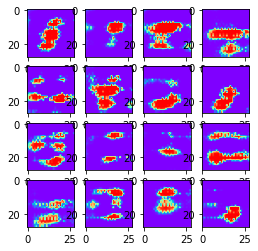

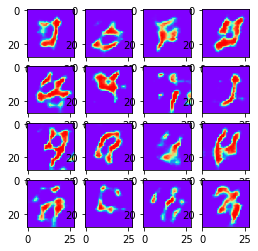

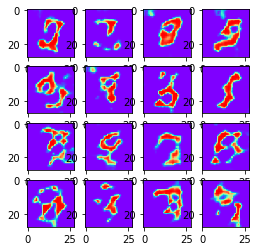

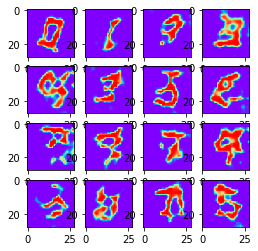

In [52]:
# 모델 훈련 및 생성 이미지 출력
train_GAN(train_dataset,30)